In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange

%matplotlib inline

# MINE on multivariate Gaussian 
Can we get unbiased estimates of the MI using MINE on relatively small dataset?

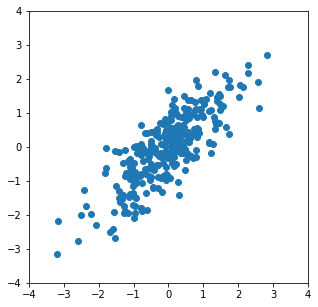

In [80]:
p = 0.8
x = np.random.multivariate_normal(mean = [0,0],cov = [[1,1*p],[1*p,1]],size = 300)
MI_groundtruth = -1/2*np.log(1-p**2)

plt.figure(figsize = (5,5))
plt.scatter(x=x[:,0],y=x[:,1])
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.show()

In [84]:
## here we define the network that learns to output T
class statistics_network(nn.Module):
    def __init__(self,input_size = 2,hidden_size=100):
        super().__init__()
        self.encoder = nn.Linear(input_size,hidden_size)
        self.hidden = nn.Linear(hidden_size,hidden_size)
        self.decoder = nn.Linear(hidden_size,1)
        nn.init.normal_(self.encoder.weight,std=0.02)
        nn.init.constant_(self.encoder.bias, 0)
        nn.init.normal_(self.hidden.weight,std=0.02)
        nn.init.constant_(self.hidden.bias, 0)
        nn.init.normal_(self.decoder.weight,std=0.02)
        nn.init.constant_(self.decoder.bias, 0)
        
        self.sp = nn.Softplus()
    def forward(self,input):
        hidden1 = self.sp(self.encoder(input))
        hidden2 = self.sp(self.hidden(hidden1))
        output = self.decoder(hidden2)
        return output
    
# and the empirical Donsker-Varadhan lower bound
def MINE_lb(joint,marginal,stat_net):
    T_joint = stat_net(joint)
    T_marginal = stat_net(marginal)
    T_exp_marginal = torch.exp(T_marginal)
    DV_lb = torch.mean(T_joint) - torch.log(torch.mean(T_exp_marginal))

    return DV_lb, T_joint, T_exp_marginal

def sample_batch(data, batch_size=100, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index,0].reshape(-1,1),data[marginal_index,1].reshape(-1,1)],axis=1)
    return batch
    
# training
def train(data,stat_net,optimizer,batch_size=100,max_epoch=np.int(1e3)):
    data = np.random.shuffle(data)
    data_test = data[-100:]
    data = data[:300]
    n_samp = data.shape[0];
    n_test = data_test.shape[0];
    n_batch = np.int(n_samp/batch_size)
    ma_et = 1
    ma_rate=0.01
    
    loss_hist = np.zeros(max_epoch)
    MI_est_hist = np.zeros(max_epoch)
    for epoch in range(max_epoch):
        joint, marginal = sample_batch(data,batch_size=batch_size), sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        joint = torch.Tensor(joint).cpu()
        marginal = torch.Tensor(marginal).cpu()
        VD_lb, t, et = MINE_lb(joint,marginal,stat_net)
        # compute loss function then step the optimizer
        optimizer.zero_grad()
        loss = -VD_lb
        loss.backward()
        optimizer.step()
        # keep track of the history of the estimate
        joint_test, marginal_test = sample_batch(data_test,batch_size=n_test), sample_batch(data_test,batch_size=n_test,sample_mode='marginal')
        joint_test = torch.Tensor(joint_test).cpu()
        marginal_test = torch.Tensor(marginal_test).cpu()
        VD_all_lb, t_all, et_all = MINE_lb(joint_test,marginal_test,stat_net)
        MI_est_hist[epoch] = VD_all_lb.detach().cpu().numpy()
    return MI_est_hist

In [85]:
batch_size = 100
n_epoch = 1000
MI_ests = []
n_reps = 100;
Gauss_MI_hist = np.zeros((n_epoch,n_reps))
for rep in tnrange(n_reps):
    GaussNet = statistics_network().cpu()
    GaussNet_optimizer = optim.Adam(GaussNet.parameters(), lr=1e-3)
    Gauss_MI_hist[:,rep] = train(x,GaussNet,GaussNet_optimizer,batch_size=batch_size,max_epoch=n_epoch)

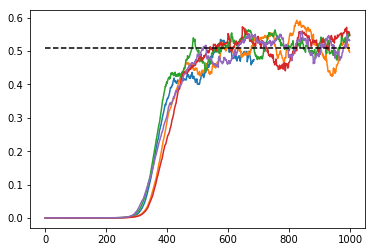

In [94]:
window = 40;
for i in range(5):
    scurve = np.convolve(np.hstack((Gauss_MI_hist[:,i*20],Gauss_MI_hist[-2*window:,i*20])), np.ones((window))/window, mode='same');
    plt.plot(scurve[:n_epoch])
plt.plot(MI_groundtruth*np.ones_like(Gauss_MI_hist[:,0]),'k--')
plt.show()

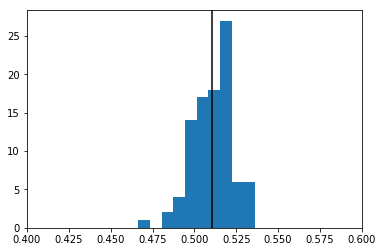

In [93]:
plt.hist(np.mean(Gauss_MI_hist[-400:,:],axis=0))
plt.axvline(x=MI_groundtruth,color='k')
plt.xlim([0.4,0.6])
plt.show()

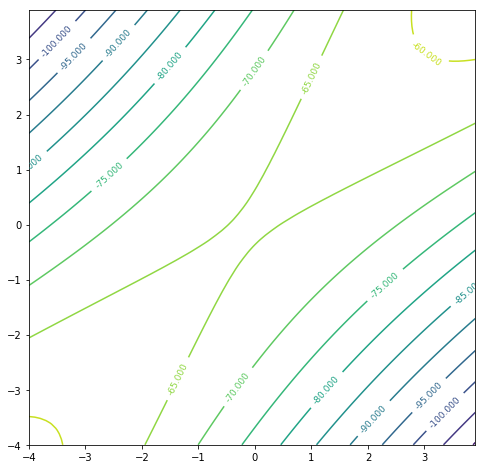

In [99]:
x = np.arange(-4, 4, 0.1)
y = np.arange(-4, 4, 0.1)
xx, yy = np.meshgrid(x, y)
xs = xx.flatten()
ys = yy.flatten()
X = torch.Tensor(np.hstack((xs.reshape(-1,1),ys.reshape(-1,1)))).cpu();
VD, t, et = MINE_lb(X,X,GaussNet)
tt = t.detach().reshape(np.shape(xx))

fig = plt.figure(figsize = (8,8))
ax = fig.subplots()
CS = ax.contour(xx,yy,tt,10)
ax.clabel(CS, fontsize=9, inline=1)
plt.show()

## Equitability Experiment
Nonlinear transformation that preserves the bound should not effect the emperical MI 

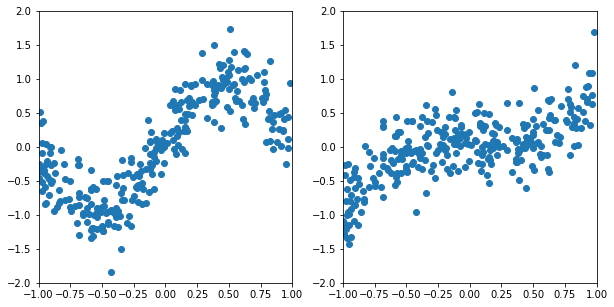

In [209]:
f = lambda muf: muf**3
g = lambda mug: np.sin(mug*3)
u = np.random.uniform(low=-1.,high=1.,size=300)
sig = .3
noise = np.random.normal(loc=0.0, scale=sig,size = 300)
x1 = np.zeros((300,2))
x2 = np.zeros((300,2))
x1[:,0] = u
x2[:,0] = u
x1[:,1] = g(u)+noise
x2[:,1] = f(u)+noise

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.scatter(x=x1[:,0],y=x1[:,1])
plt.xlim([-1,1])
plt.ylim([-2,2])
plt.subplot(1,2,2)
plt.scatter(x=x2[:,0],y=x2[:,1])
plt.xlim([-1,1])
plt.ylim([-2,2])
plt.show()

In [217]:
batch_size = 100
n_epoch = 4000
MI_ests = []
n_reps = 10;
NL1_Gauss_MI_hist = np.zeros((n_epoch,n_reps))
NL2_Gauss_MI_hist = np.zeros((n_epoch,n_reps))
for rep in tnrange(n_reps):
    NL1_GaussNet = statistics_network().cpu()
    NL1_GaussNet_optimizer = optim.Adam(NL1_GaussNet.parameters(), lr=1e-3)
    NL1_Gauss_MI_hist[:,rep] = train(x1,NL1_GaussNet,NL1_GaussNet_optimizer,batch_size=batch_size,max_epoch=n_epoch)
    NL2_GaussNet = statistics_network().cpu()
    NL2_GaussNet_optimizer = optim.Adam(NL2_GaussNet.parameters(), lr=1e-3)
    NL2_Gauss_MI_hist[:,rep] = train(x2,NL2_GaussNet,NL2_GaussNet_optimizer,batch_size=batch_size,max_epoch=n_epoch)

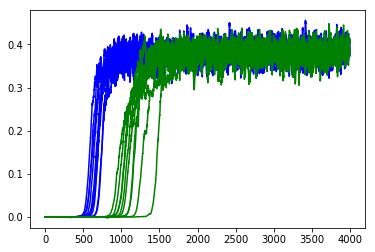

In [253]:
window = 20;
for i in range(n_reps):
    scurve1 = np.convolve(np.hstack((NL1_Gauss_MI_hist[:,i],NL1_Gauss_MI_hist[-2*window:,i])), np.ones((window))/window, mode='same');
    plt.plot(scurve1[:n_epoch],'b')
for i in range(n_reps):
    scurve2 = np.convolve(np.hstack((NL2_Gauss_MI_hist[:,i],NL2_Gauss_MI_hist[-2*window:,i])), np.ones((window))/window, mode='same');
    plt.plot(scurve2[:n_epoch],'g')
plt.show()